In [3]:
from DMpy.model import DMModel, Parameter
from DMpy.learning import dual_lr_qlearning, rescorla_wagner
from DMpy.observation import softmax
import pandas as pd
import numpy as np
import theano
import seaborn as sns
import matplotlib.pyplot as plt
theano.config.mode = 'Mode'   # this is necessary to make theano play nicely in ipython for some reason

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

# Model fitting settings

# Priors
alpha_mean = 0.5
alpha_var = 5

beta_mean = 3
beta_var = 10

# Number of ADVI iterations
advi_n = 22000

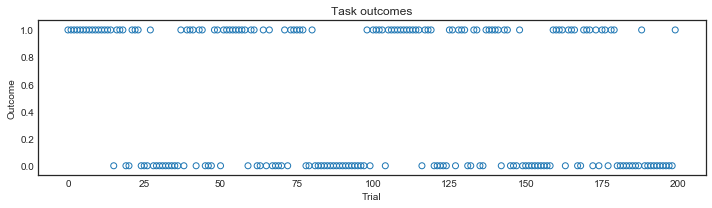

In [4]:
outcomes = np.loadtxt('task_outcomes/example_outcomes.txt')
plt.figure(figsize=(10, 3))
plt.scatter(range(0, len(outcomes)), outcomes, edgecolors='tab:blue', facecolors='None');
plt.xlabel("Trial")
plt.ylabel("Outcome")
plt.title("Task outcomes")
plt.tight_layout()

### Model

The model we'll use is an extension of a standard Rescorla-Wagner model with two learning rates, one for better than expected outcomes and one from worse than expected outcomes (taken from Lefebrvre et al., 2017, Nature Human Behaviour).

Value on each trial is updated according to:

\begin{equation*}
\delta = (outcome - Q_t)
\end{equation*}

\begin{equation*}
Q_{t+1} = Q_t + \begin{matrix}
\alpha^+ \cdot \delta&\text{if } \delta > 0 \\
\alpha^- \cdot \delta&\text{if } \delta < 0
\end{matrix}
\end{equation*}

Priors here are normally distributed.

## Two groups, hierarchical fitting, $d$~0.5


Actual effect size = -0.564762900486


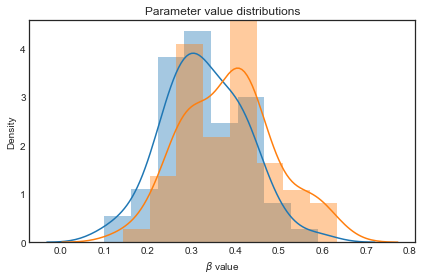

In [16]:
n_groupA = 60
n_groupB = 60

alpha_p_values = np.random.normal(0.3, 0.05, n_groupA + n_groupB)
beta = np.random.normal(3, 0.3, n_groupA + n_groupB)

alpha_n_values_a = np.random.normal(0.32, 0.1, n_groupA)
alpha_n_values_b = np.random.normal(0.36, 0.1, n_groupB)

alpha_n_values = np.concatenate([alpha_n_values_a, alpha_n_values_b])
if np.any(alpha_n_values < 0):
    raise ValueError("Alpha values below zero")

sns.distplot(alpha_n_values_a, label="Group A, $\mu$ = 2, $\sigma$ = 0.5", color='tab:blue');
sns.distplot(alpha_n_values_b, label="Group B, $\mu$ = 3, $\sigma$ = 0.5", color='tab:orange');
plt.xlabel("$\\beta$ value")
plt.ylabel("Density")
plt.title("Parameter value distributions")
plt.tight_layout()

print "Actual effect size = {0}".format(cohen_d(alpha_n_values_a, alpha_n_values_b))


### Simulation

Once again we simulate data from this distribution of parameters.

In [17]:
value = Parameter(r'$Q$', 'fixed', mean=0.5, dynamic=True)
q = Parameter(r'$Q$', 'fixed', mean=0.5, dynamic=True)
alpha_p = Parameter(r'$\alpha^p$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
alpha_n = Parameter(r'$\alpha^n$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
b = Parameter(r'$\beta$', 'normal', lower_bound=0, upper_bound=10, mean=beta_mean, variance=beta_var)
model = DMModel(dual_lr_qlearning, [value, alpha_p, alpha_n], softmax, [b], name='Dual learning rate',
                       logp_function = 'bernoulli')

sim_results, sim_result_file = model.simulate(outcomes, learning_parameters={r'$Q$': [0.5] * (n_groupA + n_groupB),
                                                                             r'$\alpha^p$': alpha_p_values,
                                                                             r'$\alpha^n$': alpha_n_values},
               observation_parameters={r'$\beta$': beta}, response_format='discrete', combinations=False,
                                              output_file='two_group_sim_d03.txt')


c:\users\toby\onedrive - university college london\dmpy\DMpy\model.py:1141: Warning: Fewer outcome lists than simulated subjects, attempting to use same outcomes for each subject (number of outcome lists = 1, number of subjects = 120
  p_combinations.shape[0]), Warning)


Saving simulated responses to two_group_sim_d03.txt
Finished simulating


Loading multi-subject data with 120 subjects, 1 runs per subject
Loaded data, 120 subjects with 200 trials * 1 runs
Created model
Fitting model using NUTS
Performing non-hierarchical model fitting for 120 subjects


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\pymc3-3.3-py2.7.egg\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
Sequential sampling (2 chains in 1 job)
NUTS: [$\beta$_interval__, $\alpha^n$_interval__, $\alpha^p$_interval__]
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [17:39<00:00,  3.30it/s]



PARAMETER ESTIMATES

Performing parameter recovery tests...
Finished model fitting in 2253.82478257 seconds


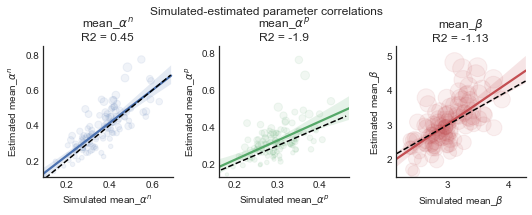

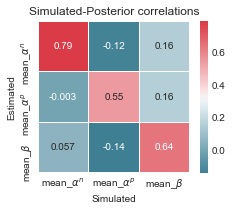

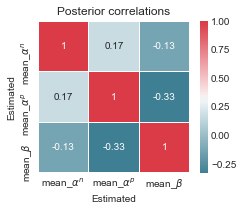

In [18]:
model.fit(sim_result_file, fit_method='mcmc', suppress_table=True, recovery=True, 
          sample_kwargs=dict(njobs=1, draws=3000), plot=False)
non_hierarchical_params = model.parameter_table

Loading multi-subject data with 120 subjects, 1 runs per subject
Loaded data, 120 subjects with 200 trials * 1 runs
Created model
Fitting model using NUTS
Performing hierarchical model fitting for 120 subjects


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [$\beta$_interval__, $\beta$_group_sd_interval__, $\beta$_group_mu_interval__, $\alpha^n$_interval__, $\alpha^n$_group_sd_interval__, $\alpha^n$_group_mu_interval__, $\alpha^p$_interval__, $\alpha^p$_group_sd_interval__, $\alpha^p$_group_mu_interval__]
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [10:24<00:00,  5.61it/s]
The number of effective samples is smaller than 25% for some parameters.



PARAMETER ESTIMATES

Performing parameter recovery tests...
Finished model fitting in 1309.01894515 seconds


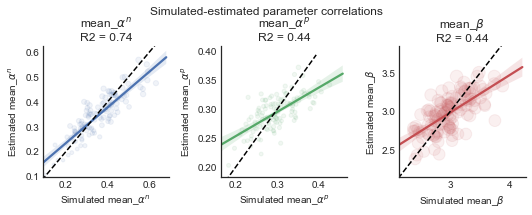

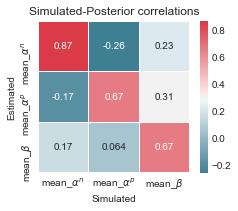

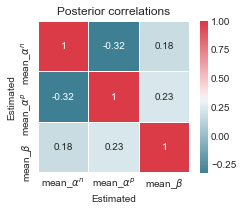

In [19]:
q = Parameter(r'$Q$', 'fixed', mean=0.5, dynamic=True)
alpha_p = Parameter(r'$\alpha^p$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
alpha_n = Parameter(r'$\alpha^n$', 'normal', lower_bound=0, upper_bound=1, mean=alpha_mean, variance=alpha_var)
b = Parameter(r'$\beta$', 'normal', lower_bound=0, upper_bound=10, mean=beta_mean, variance=beta_var)
model = DMModel(dual_lr_qlearning, [value, alpha_p, alpha_n], softmax, [b], name='Dual learning rate',
                       logp_function = 'bernoulli')
model.fit(sim_result_file, fit_method='mcmc', suppress_table=True, recovery=True, hierarchical=True,
          sample_kwargs=dict(njobs=1, draws=3000), plot=False)
hierarchical_params = model.parameter_table

True effect size = -0.56
Non-hierarchical effect size = -0.47
Hierarchical effect size = -0.55


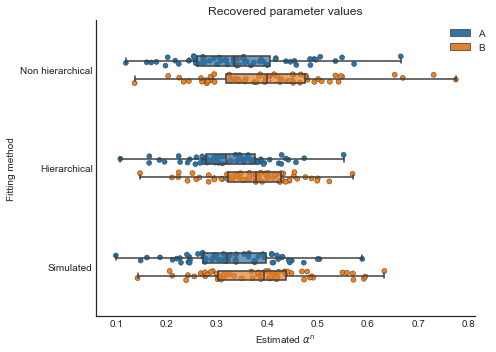

In [22]:
alpha_n_recovered_values = {'method': [], 'value': [], 'group': []}
alpha_n_recovered_values['value'] += non_hierarchical_params[[c for c in non_hierarchical_params 
                                                          if 'alpha^n' in c and 'mean' in c]].values.flatten().tolist()
alpha_n_recovered_values['method'] += ['Non hierarchical'] * len(non_hierarchical_params)
alpha_n_recovered_values['group'] += ['A'] * n_groupA + ['B'] * n_groupB

alpha_n_recovered_values['value'] += hierarchical_params[[c for c in hierarchical_params 
                                                      if 'alpha^n' in c and 'mean' in c]].values.flatten().tolist()
alpha_n_recovered_values['method'] += ['Hierarchical'] * len(hierarchical_params)
alpha_n_recovered_values['group'] += ['A'] * n_groupA + ['B'] * n_groupB

alpha_n_recovered_values['value'] += np.concatenate([alpha_n_values_a, alpha_n_values_b]).tolist()
alpha_n_recovered_values['method'] += ['Simulated'] * len(model.parameter_table)
alpha_n_recovered_values['group'] += ['A'] * n_groupA + ['B'] * n_groupB
alpha_n_recovered_values['Subject'] = np.tile(np.arange(0, n_groupA + n_groupB), 3)

alpha_n_recovered_values = pd.DataFrame(alpha_n_recovered_values)

plt.figure(figsize=(7, 5))
sns.stripplot(x="value", y="method", hue='group', data=alpha_n_recovered_values, jitter=True, color=".7", dodge=True, spacing=0.45,
              linewidth=0.5, alpha=1, palette=['tab:blue', 'tab:orange'] * 3, zorder=1);
ax = sns.boxplot(x="value", y="method", hue='group', data=alpha_n_recovered_values, dodge=True, spacing=1.8,
                 palette=['tab:blue', 'tab:orange'] * 3, whis=np.inf, showmeans=True, meanline=True, 
                 meanprops={'zorder': 12, 'linewidth': 1},
           width=0.2, boxprops={"zorder":10}, whiskerprops={'zorder':10}, medianprops={'zorder':11});
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
plt.title("Recovered parameter values");
plt.xlabel("Estimated $\\alpha^n$");
plt.ylabel("Fitting method");
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1))
sns.despine()
plt.tight_layout()

print "True effect size = {0}".format(np.round(cohen_d(alpha_n_values_a, alpha_n_values_b), 2))
print "Non-hierarchical effect size = {0}".format(np.round(cohen_d(alpha_n_recovered_values[alpha_n_recovered_values.method == 
                                                                      'Non hierarchical'].value[:50], 
             alpha_n_recovered_values[alpha_n_recovered_values.method == 'Non hierarchical'].value[50:]), 2))
print "Hierarchical effect size = {0}".format(np.round(cohen_d(alpha_n_recovered_values[alpha_n_recovered_values.method == 
                                                                      'Hierarchical'].value[:50], 
             alpha_n_recovered_values[alpha_n_recovered_values.method == 'Hierarchical'].value[50:]), 2))

### Results

Here we recover the group difference successfully, although the hierarchical approach is slightly more sensitive than the non-hierarchical approach.